# **Detecção de Spam de E-mail**

Neste tutorial, usaremos um classificador Naive Bayes e uma Rede Neural Convolucional para concluir uma tarefa clássica de classificação de texto, a filtragem de spam.

Usaremos um conjunto de dados de spam do [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) 

[Classifying data using the Multinomial Naive Bayes algorithm](https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/)


### **Importando Bibliotecas**

In [1399]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

# !pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# !pip install --upgrade scikit-learn 
from sklearn.model_selection import TunedThresholdClassifierCV # Está disponível no scikit-learn 1.5

# !pip install scikeras
from scikeras.wrappers import KerasClassifier


# !pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# !pip install tqdm
from tqdm import tqdm

# !pip install tensorflow
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

# !pip install keras ou pip install --upgrade keras
from keras import ops

# !pip install fast-ml
from fast_ml.model_development import train_valid_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Daniela
[nltk_data]     Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Daniela
[nltk_data]     Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Daniela
[nltk_data]     Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Lendo os Dados**

Usaremos um conjunto de dados de spam do [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).

1) Baixe os dados do repositório [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) .

2) Descompacte o arquivo e reformate-o como um arquivo .csv.

3) Carregue este arquivo .csv do seu sistema local para o seu notebook 

In [1400]:
data = pd.read_csv("SMSSpamCollection.csv", sep='\t', header=None)

### **Análise Exploratória de Dados**

Antes do pré-processamento, é sempre bom organizar os dados e examiná-los em busca de problemas subjacentes, como dados ausentes ou duplicados. Traçar os dados também pode nos ajudar a ver se os dados estão equilibrados.

In [1401]:
data.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [1402]:
# Renomear colunas
data.rename(columns={0:'classification', 1:'text'}, inplace=True)

In [1403]:
data.shape

(5572, 2)

In [1404]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   classification  5572 non-null   object
 1   text            5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [1405]:
# Não há dados faltantes
data.isnull().sum()

classification    0
text              0
dtype: int64

In [1406]:
# Existem dados duplicados neste conjunto de dados
data.duplicated().sum()

403

In [1407]:
data.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


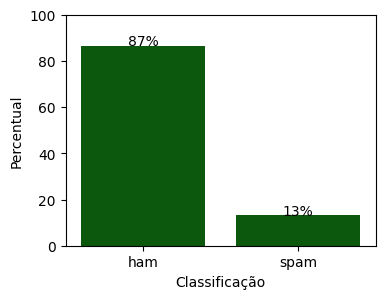

In [1408]:
# Distribuição da variável alvo

fig, ax = plt.subplots(1, 1, figsize=(4,3))

g1 = sns.countplot(data, x="classification", stat="percent", ax=ax, color='#006400')
g1.set_ylim(0,100)

for p in g1.patches:
   width = p.get_width()
   height = p.get_height()
   x ,y = p.get_xy()
   g1.annotate('{:.0f}%'.format(height), (x + width/2, y + height), ha='center')

ax.set_xlabel("Classificação")
ax.set_ylabel("Percentual")
                 
plt.show()

O gráfico indica que a distribuição das classes é desigual, com o spam representando apenas 13% dos dados. 

Portanto, temos um conjunto de dados **desequilibrado**, o que pode ser uma preocupação, pois pode levar ao overfitting. 

Embora isso não signifique que os dados de treinamento serão superajustados, é bom estar ciente disso antecipadamente caso precisemos usar técnicas de sobreamostragem (também conhecida como upsampling) ou subamostragem (também conhecida como downsampling). Com isso em mente, eliminaremos os dados duplicados e prosseguiremos primeiro com o treinamento de nosso modelo nessa distribuição desequilibrada.


In [1409]:
# Excluindo dados duplicados
data = data.drop_duplicates()

In [1410]:
# Resetando os indices do dataset
data = data.reset_index(drop=True)

In [1411]:
data.shape

(5169, 2)

In [1412]:
data.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### **Dividindo o Conjunto de Dados em Treino e Teste**

* Dados de treinamento: usado para treinar o modelo.
* Dados de validação: usado para comparar diferentes modelos e no ajuste de hiperparâmetros. Ao usar validação cruzada não é necessário um conjunto de validação, pois a função cross_val_score irá fazer o split no conjunto de treinamento separando os dados em treino e validação.
* Dados de teste: usado para avaliação final do modelo. Não deve ser usado durante o treino e a validação.

As seguintes proporções podem ser adotadas:

* 1 Opção:
    * 70% dos dados para treino
    * 15% dos dados para teste
    * 15% dos dados para validação

* 2 Opção:
    * 70% dos dados para treino
    * 30% dos dados para teste


**IREMOS ADOTAR A SEGUNDA OPÇÃO E FAREMOS VALIDAÇÃO CRUZADA**

Ao avaliar diferentes configurações (“hiperparâmetros”) para estimadores, existe o risco de ajuste excessivo no conjunto de teste porque os parâmetros podem ser ajustados até que o estimador tenha um desempenho ideal. Dessa forma, o conhecimento sobre o conjunto de testes pode “vazar” para o modelo e as métricas de avaliação não informam mais sobre o desempenho da generalização. 

Para resolver este problema, ainda outra parte do conjunto de dados pode ser considerada o chamado “conjunto de validação”: o treinamento prossegue no conjunto de treinamento, após o qual a avaliação é feita no conjunto de validação, e quando o experimento parece ser bem-sucedido , a avaliação final pode ser feita no conjunto de testes.

No entanto, ao particionar os dados disponíveis em três conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para aprender o modelo, e os resultados podem depender de uma escolha aleatória específica para o par de conjuntos (treinamento, validação).

Uma solução para este problema é um procedimento denominado **validação cruzada** (abreviadamente CV). Um conjunto de teste ainda deve ser apresentado para avaliação final, mas o conjunto de validação não é mais necessário ao fazer o CV. Na abordagem básica, chamada k-fold CV, o conjunto de treinamento é dividido em k conjuntos menores. O seguinte procedimento é seguido para cada uma das k “dobras”:

* Um modelo é treinado usando k-1 das dobras como dados de treinamento;
* O modelo resultante é validado na parte restante dos dados (ou seja, é usado como um conjunto de testes para calcular uma medida de desempenho, como a precisão)

Usaremos a função cross_val_score para realizar a validação cruzada

Ao utilizar técnicas de balanceamento de dados não podemos utilizar a função cross_val_score, pois o balanceamento só pode ser realizado no split de dados de treinamento. O split que será utilizado para validação não pode ser balanceamento. 

Algumas alternativas:
* **KFold** divide todas as amostras em grupos de amostras, chamados dobras de tamanhos iguais. A função de previsão é aprendida usando dobras, e a dobra deixada de fora é usada para validação.

from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
for train, valid in kf.split(X_train):
    print("%s %s" % (train, valid))

* **StratifiedKFold** é uma variação de k-fold que retorna dobras estratificadas: cada conjunto contém aproximadamente a mesma porcentagem de amostras de cada classe alvo que o conjunto completo.

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
for train, valid in skf.split(X_train, y_train):
    print("%s %s" % (train, valid))


[Validação Cruzada](https://scikit-learn.org/stable/modules/cross_validation.html)

In [1413]:
X = data['text'].values
y = data['classification'].values

In [1414]:
# Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


In [1415]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3618,), (3618,), (1551,), (1551,))

In [1416]:
X_train

array(["I think we're going to finn's now, come",
       "Yeah he got in at 2 and was v apologetic. n had fallen out and she was actin like spoilt child and he got caught up in that. Till 2! But we won't go there! Not doing too badly cheers. You? ",
       'Hi baby ive just got back from work and i was wanting to see u allday! I hope i didnt piss u off on the phone today. If u are up give me a call xxx',
       ...,
       "You will be receiving this week's Triple Echo ringtone shortly. Enjoy it!",
       "We're done...", 'Did you stitch his trouser'], dtype=object)

In [1417]:
y_train

array(['ham', 'ham', 'ham', ..., 'spam', 'ham', 'ham'], dtype=object)

#### **Codificando os Rótulos de Destino**

In [1418]:
# O LabelEncoder é usado para codificar rótulos de destino com valor entre 0 e n_classes-1.
# Este transformador deve ser usado para codificar valores alvo, ou seja y, e não a entrada X.

label = LabelEncoder()

y_train = label.fit_transform(y_train)

y_test = label.transform(y_test)

In [1419]:
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [1420]:
label.inverse_transform(y_train)

array(['ham', 'ham', 'ham', ..., 'spam', 'ham', 'ham'], dtype=object)

In [1421]:
label.classes_

array(['ham', 'spam'], dtype=object)

In [1422]:
np.unique(y_train)

array([0, 1])

In [1423]:
label.inverse_transform(np.unique(y_train))

array(['ham', 'spam'], dtype=object)

### **Pré-processamento e Limpeza dos Dados**

Depois de dividir os dados, podemos começar a pré-processá-los. Isso inclui tarefas de processamento de linguagem natural, como tokenização, remoção de palavras irrelevantes (stop words), stemização e lematização.

Em seguida, usaremos uma técnica popular de incorporação de palavras, chamada bag-of-words , para extrair características do texto. Esta técnica calcula especificamente a frequência de palavras dentro de um determinado documento, o que pode nos ajudar a classificar documentos, assumindo que documentos semelhantes possuem conteúdo semelhante.

### **Limpeza de Texto, Tokenização, Remoção de Stopwords, Lematização e Stemização**

In [1424]:
# Função para remover Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [1425]:
def text_clean(text):
    # Transforma o Texto em Minúsculas
    texto = text.lower()

    # Remove URLs do Texto
    texto = re.sub(r'https?://\S+', ' ', texto)

    # Remove pontuação e caracteres especiais
    texto = re.sub(r'[^\w\s]', ' ', texto)

    # Remove notação ordinal
    texto = texto.replace('ª', ' ').replace('º', ' ').replace('°', ' ').replace("'", ' ')

    # Remove dígitos
    texto = re.sub(r'\d', ' ', texto)

    # Remove Tags HTML
    texto = re.sub(r'<.*?>', '', texto)

    return texto

In [1426]:
# Função para Tokenização
def tokenizer(text):
    tokens = word_tokenize(text)
    
    return tokens

In [1427]:
# Função para Remover Stop Words
def stopwords(text):
    stopwords_pt = nltk.corpus.stopwords.words('english') 
    remove_stopwords = []

    for token in text:
        if token not in stopwords_pt:
            remove_stopwords.append(token)

    return remove_stopwords

In [1428]:
# Função para Lematização
def lemmatizacao(text):
    lemmer = WordNetLemmatizer()
    texto = [lemmer.lemmatize(token) for token in text]

    return texto

In [1429]:
# Função para Stemização
def stemizacao(text):
    porter = PorterStemmer()
    texto = [porter.stem(token) for token in text]

    return texto

In [1430]:
# Função de Pré-processamento do Texto
def text_processing(dc, rm_stop, method):
    df = dc.copy()
    i = 0
    for text in tqdm(df):
        # Remove Emojis
        texto = remove_emoji(text)

        # Remove Pontuações e Caracteres Especiais
        texto = text_clean(texto)

        # Faz a Tokenização
        texto = tokenizer(texto)

        # Remove palavras irrelevantes
        if rm_stop == True:
            texto = stopwords(texto)

        # Lematização: normalmente preferida à lematização
        if method == 'L':
            texto = lemmatizacao(texto)
            
        # Stimização
        if method == 'S':
            texto = stemizacao(texto)
        
        df[i] = " ".join(texto)
        
        i = i + 1

    return df

Como podemos processar os dados de diversas maneiras, devemos modelar diferentes versões de dados pré-processados ​​para entender qual variação de dados fornece os resultados ideais em nosso modelo. 

In [1431]:
#preprocessed data: Lemm + stopword removal 
X_train_1 = text_processing(X_train, True, 'L')
X_test_1 = text_processing(X_test, True, 'L') 

#preprocessed data: Lemm + no stopword removal 
X_train_2 = text_processing(X_train, False, 'L')
X_test_2 = text_processing(X_test, False, 'L') 

#preprocessed data: Stem + stopword removal 
X_train_3 = text_processing(X_train, True, 'S')
X_test_3 = text_processing(X_test, True, 'S') 

#preprocessed data: Stem + no stopword removal 
X_train_4 = text_processing(X_train, False, 'S')
X_test_4 = text_processing(X_test, False, 'S') 

100%|██████████| 1551/1551 [00:00<00:00, 1584.09it/s]


In [1432]:
X_train_1

array(['think going finn come',
       'yeah got v apologetic n fallen actin like spoilt child got caught till go badly cheer',
       'hi baby ive got back work wanting see u allday hope didnt piss u phone today u give call xxx',
       ..., 'receiving week triple echo ringtone shortly enjoy', 'done',
       'stitch trouser'], dtype=object)

In [1433]:
X_train_2

array(['i think we re going to finn s now come',
       'yeah he got in at and wa v apologetic n had fallen out and she wa actin like spoilt child and he got caught up in that till but we won t go there not doing too badly cheer you',
       'hi baby ive just got back from work and i wa wanting to see u allday i hope i didnt piss u off on the phone today if u are up give me a call xxx',
       ...,
       'you will be receiving this week s triple echo ringtone shortly enjoy it',
       'we re done', 'did you stitch his trouser'], dtype=object)

In [1434]:
X_train_3

array(['think go finn come',
       'yeah got v apologet n fallen actin like spoilt child got caught till go badli cheer',
       'hi babi ive got back work want see u allday hope didnt piss u phone today u give call xxx',
       ..., 'receiv week tripl echo rington shortli enjoy', 'done',
       'stitch trouser'], dtype=object)

In [1435]:
X_train_4

array(['i think we re go to finn s now come',
       'yeah he got in at and wa v apologet n had fallen out and she wa actin like spoilt child and he got caught up in that till but we won t go there not do too badli cheer you',
       'hi babi ive just got back from work and i wa want to see u allday i hope i didnt piss u off on the phone today if u are up give me a call xxx',
       ...,
       'you will be receiv thi week s tripl echo rington shortli enjoy it',
       'we re done', 'did you stitch hi trouser'], dtype=object)

### **Multinomial Naive Bayes**

O classificador Naive Bayes é um algoritmo de aprendizado de máquina supervisionado , comumente aplicado em casos de uso que envolvem sistemas de recomendação, classificação de texto e análise de sentimento . Por ter um bom desempenho com conjuntos de dados com alta dimensionalidade, é um classificador preferido para classificação de texto em particular.

Naive Bayes (NB) também é um algoritmo de aprendizagem generativo, o que significa que modela a distribuição de pontos de dados para uma determinada classe ou categoria. Este classificador probabilístico é baseado no Teorema de Bayes , o que significa que este classificador bayesiano usa probabilidades condicionais e probabilidades anteriores para calcular as probabilidades posteriores.

Os classificadores Naive Bayes funcionam de maneira diferente, pois operam sob algumas suposições principais, ganhando o título de ingênuos . Ele assume que os preditores em um modelo Naive Bayes são condicionalmente independentes ou não relacionados a qualquer outro recurso do modelo. Também pressupõe que todos os recursos contribuem igualmente para o resultado.

Embora essas suposições sejam frequentemente violadas em cenários do mundo real (por exemplo, uma palavra subsequente em um e-mail depende da palavra que a precede), elas simplificam um problema de classificação, tornando-o mais tratável computacionalmente. Ou seja, agora será necessária apenas uma única probabilidade para cada variável, o que, por sua vez, facilita o cálculo do modelo. Apesar desta suposição de independência irrealista, **o algoritmo de classificação funciona bem, especialmente com amostras pequenas**.

Neste tutorial, usaremos o scikit-learn para percorrer diferentes tipos de algoritmos Naive Bayes, focando principalmente em uma tarefa popular de classificação de texto (filtragem de spam) usando Multinomial Naive Bayes.

**Tipos de classificadores Naïve Bayes**

Não existe apenas um tipo de classificador Naïve Bayes. Os tipos mais populares diferem com base nas distribuições dos valores dos recursos. Alguns deles incluem: 

* Gaussian Naïve Bayes (GaussianNB) : Esta é uma variante do classificador Naïve Bayes, que é usado com distribuições gaussianas - ou seja, distribuições normais - e variáveis ​​contínuas. Este modelo é ajustado encontrando a média e o desvio padrão de cada classe. 
* Multinomial Naïve Bayes (MultinomialNB) : Este tipo de classificador Naïve Bayes assume que os recursos são de distribuições multinomiais. Essa variante é útil ao usar dados discretos, como contagens de frequência, e normalmente é aplicada em casos de uso de processamento de linguagem natural, como classificação de spam. 
* Bernoulli Naïve Bayes (BernoulliNB) : Esta é outra variante do classificador Naïve Bayes, que é usado com variáveis ​​booleanas - ou seja, variáveis ​​com dois valores, como True e False ou 1 e 0. 


[Classifying data using the Multinomial Naive Bayes algorithm](https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/)

[What are Naïve Bayes classifiers?](https://www.ibm.com/topics/naive-bayes)

### **Bag-of-Words**

O modelo bag-of-words é comumente usado para gera uma contagem de frequência de cada palavra de um determinado texto.

O modelo bag-of-words é uma forma de representar dados de texto para algoritmos de aprendizado de máquina. Algoritmos de aprendizado de máquina não podem trabalhar diretamente com texto bruto; o texto deve ser convertido em números (vetoriais) de comprimento fixo bem definidos.

O modelo bag-of-words envolve duas coisas:
* Um vocabulário de palavras conhecidas.
* Uma medida da presença de palavras conhecidas.

É chamado de bag-of-words, porque qualquer informação sobre a ordem ou estrutura das palavras no documento é descartada. O modelo se preocupa apenas em saber se as palavras conhecidas ocorrem no documento, e não em que parte do documento. A complexidade vem tanto na decisão de como projetar o vocabulário de palavras conhecidas (ou tokens) e como pontuar a presença de palavras conhecidas.

**CountVectorizer**: é uma classe do scikit-learn que transforma uma coleção de documentos de texto em uma matriz numérica de contagens de palavras ou tokens. Esta implementação produz uma representação esparsa das contagens. 

Esta classe possui vários parâmetros que também podem auxiliar em tarefas de pré-processamento de texto, como:
* remoção de stop word
* limites de contagem de palavras (ou seja, máximos e mínimos)
* limites de vocabulário
* criação de n-gramas e muito mais.

**TfidfVectorizer**: converte uma coleção de documentos brutos em uma matriz de recursos do TF-IDF.

[Using CountVectorizer for NLP feature extraction](https://www.ibm.com/reference/python/countvectorizer#:~:text=CountVectorizer%20is%20a%20class%20in,of%20word%20or%20token%20counts.)

In [1436]:
# O CountVectorizer 
# Converte uma coleção de documentos de texto em uma matriz de contagens de tokens. Por padrão, ele converterá seu texto para letras minúsculas e usará a codificação utf-8.
# Produz uma matriz esparsa das contagens a partir do conjunto de dados.
# Se você não fornecer um dicionário a priori e não usar um analisador que faça algum tipo de seleção de recursos, o número de recursos será igual ao tamanho do vocabulário encontrado na análise dos dados.

vectorizer = CountVectorizer()

X_train_1_count = vectorizer.fit_transform(X_train_1)
X_test_1_count = vectorizer.transform(X_test_1)

X_train_2_count = vectorizer.fit_transform(X_train_2)
X_test_2_count = vectorizer.transform(X_test_2)

X_train_3_count = vectorizer.fit_transform(X_train_3)
X_test_3_count = vectorizer.transform(X_test_3)

X_train_4_count = vectorizer.fit_transform(X_train_4)
X_test_4_count = vectorizer.transform(X_test_4)

In [1437]:
tfidf = TfidfVectorizer() 

X_train_1_tfidf = tfidf.fit_transform(X_train_1)
X_test_1_tfidf= tfidf.transform(X_test_1)

X_train_2_tfidf = tfidf.fit_transform(X_train_2)
X_test_2_tfidf= tfidf.transform(X_test_2)

X_train_3_tfidf = tfidf.fit_transform(X_train_3)
X_test_3_tfidf= tfidf.transform(X_test_3)

X_train_4_tfidf = tfidf.fit_transform(X_train_4)
X_test_4_tfidf= tfidf.transform(X_test_4)

In [1438]:
pd.DataFrame(data=X_train_4_count.toarray(), columns=vectorizer.get_feature_names_out())

,aa,aah,aaooooright,aathi,abdomen,abeg,aberdeen,abi,abil,abiola,...,zero,zf,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada,èn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1439]:
pd.DataFrame(data=X_train_4_tfidf.toarray(), columns=tfidf.get_feature_names_out())

,aa,aah,aaooooright,aathi,abdomen,abeg,aberdeen,abi,abil,abiola,...,zero,zf,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada,èn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Métricas de Avaliação**


* **Balanced_Accuracy**: Mede a proporção de previsões corretas feitas pelo modelo. É uma métrica para lidar com conjuntos de dados desbalanceados. Faz o cálculo da acurácia de forma balanceada. 

* **Precision**: Mede a proporção de previsões positivas feitas pelo modelo que estão corretas. Essa métrica ajudará a minimizar o número de falsos positivos (ou seja, o número de textos não-spam que acabam em spam).

* **Recall (Sensibilidade)**: Mede a proporção de exemplos positivos que foram corretamente identificados pelo modelo. Essa métrica ajudará a minimizar o número de falsos negativos (ou seja, o número de textos spam que acabam em não-spam).

* **F1-Score**: É a média harmônica entre a Precisão e o Recall e fornece um equilíbrio entre essas duas métricas. Ele é útil quando você deseja levar em consideração tanto os falsos positivos quanto os falsos negativos.

verdadeiro positivo: quando o paciente tem uma doença e o teste classifica como doente
                     uma pessoa realmente grávida (positivo) e classificada como grávida (positivo)

verdadeiro negativo: quando o paciente não tem a doença e o teste classifica como não doente
                     uma pessoa que realmente não está grávida (negativo) e é classificada como não grávida (negativo).

falsos positivos:    quando o paciente não tem a doença mas o teste acusa que tem
                     uma pessoa que realmente não está grávida (negativo) e é classificada como grávida (positivo)

falsos negativos:    quando o paciente tem a doença mas o resultado acusa que não tem.
                     uma pessoa realmente grávida (positivo) e é classificada como não grávida (negativo)

In [1440]:
# Levando em conta que os dados estão desbalanceados, as duas métricas escolhidas foram a balanced_accuracy_score e f1_score
# balanced_accuracy_score é uma métrica de acurácia para lidar com dados desbalanceados
# f1_score com average igual a "macro", pois simplesmente calcula a média das métricas binárias, dando peso igual a cada classe.

def evaluate_model(real, predictions):
    accuracy = balanced_accuracy_score(real, predictions)
    f1score = f1_score(real, predictions, average="macro") 

    print(f"Balanced_Accuracy: {round(accuracy,2)*100}% F1-Score: {round(f1score,2)*100}%")

#### **Modelo**

In [1441]:
def model(X_train, y_train):
    kf = StratifiedKFold(n_splits=5)

    # Definição do Modelo
    base_model = MultinomialNB()

    # Instancia o Classificador para Definir o Limite de Decisão (Threshold)
    # O TunedThresholdClassifierCV é um classificador que pós-ajusta o limite de decisão usando validação cruzada.
    # Este estimador pós-ajusta o limite de decisão (ponto de corte) que é usado para converter estimativas de probabilidade posteriores (ou seja, saída de predict_proba) 
    # ou pontuações de decisão (ou seja, saída de decision_function) em um rótulo de classe. O ajuste é feito otimizando uma métrica binária, potencialmente restringida por outra métrica.
    model_tuned = TunedThresholdClassifierCV(base_model, scoring='balanced_accuracy') 

    # Treina o Modelo e Ajusta o Limite de Decisão
    model_tuned.fit(X_train, y_train)
    print(f'Threshold {model_tuned.best_threshold_:.3f}')

    # Validação Cruzada
    scores = cross_val_score(model_tuned, X_train, y_train, cv=kf, scoring='balanced_accuracy', n_jobs=-1)   
    print("Média: {} Desvio Padrão: {}".format(round(scores.mean(), 2), round(scores.std(),3)))

    return model_tuned

In [1442]:
#Lemm + stopword removal 
print("--> Lemm + stopword removal + CountVectorizer") 
model_count_1 = model(X_train_1_count, y_train)

#Lemm + no stopword removal 
print("\n--> Lemm + no stopword removal + CountVectorizer") 
model_count_2 = model(X_train_2_count, y_train)

#Stem + stopword removal 
print("\n--> Stem + stopword removal + CountVectorizer") 
model_count_3 = model(X_train_3_count, y_train)

#Stem + no stopword removal 
print("\n--> Stem + no stopword removal + CountVectorizer") 
model_count_4 = model(X_train_4_count, y_train)

--> Lemm + stopword removal + CountVectorizer
Threshold 0.354
Média: 0.95 Desvio Padrão: 0.01

--> Lemm + no stopword removal + CountVectorizer
Threshold 0.545
Média: 0.95 Desvio Padrão: 0.012

--> Stem + stopword removal + CountVectorizer
Threshold 0.434
Média: 0.95 Desvio Padrão: 0.011

--> Stem + no stopword removal + CountVectorizer
Threshold 0.414
Média: 0.95 Desvio Padrão: 0.014


In [1443]:
#Lemm + stopword removal 
print("--> Lemm + stopword removal + TfidfVectorizer") 
model_tfidf_1 = model(X_train_1_tfidf, y_train)

#Lemm + no stopword removal 
print("\n--> Lemm + no stopword removal + TfidfVectorizer") 
model_tfidf_2 = model(X_train_2_tfidf, y_train)

#Stem + stopword removal 
print("\n--> Stem + stopword removal + TfidfVectorizer") 
model_tfidf_3 = model(X_train_3_tfidf, y_train)

#Stem + no stopword removal 
print("\n--> Stem + no stopword removal + TfidfVectorizer") 
model_tfidf_4 = model(X_train_4_tfidf, y_train)

--> Lemm + stopword removal + TfidfVectorizer
Threshold 0.171
Média: 0.93 Desvio Padrão: 0.019

--> Lemm + no stopword removal + TfidfVectorizer
Threshold 0.110
Média: 0.92 Desvio Padrão: 0.013

--> Stem + stopword removal + TfidfVectorizer
Threshold 0.161
Média: 0.93 Desvio Padrão: 0.016

--> Stem + no stopword removal + TfidfVectorizer
Threshold 0.110
Média: 0.92 Desvio Padrão: 0.011


#### **Modelo Escolhido:** Lemm + stopword removal + CountVectorizer

Escolhemos o modelo que obteve o melhor desempenho na validação cruzada, ou seja, média de balanced accuracy alto e desvio padrão baixo.

Em nossas diferentes variações de modelo, descobrimos que o modelo que usa lematização, com remoção de palavras irrelevantes e CountVectorizer supera os demais modelos com uma pontuação de media de Balanced Accuracy de 95% e Desvio Padrão igual a 0.01.

Depois de aplicarmos o modelo Multinomial Naive Bayes às nossas diferentes variantes com os dados de treinamento, podemos avaliar o desempenho do estimador usando os dados de teste.

In [1444]:
#Lemm + stopword removal 
print("--> AVALIAÇÃO NO TESTE: Lemm + stopword removal + CountVectorizer") 

# Predição no Conjunto de Teste
predictions_naive = model_count_1.predict(X_test_1_count)

# Avaliação Final do Modelo
evaluate_model(y_test, predictions_naive)

--> AVALIAÇÃO NO TESTE: Lemm + stopword removal + CountVectorizer
Balanced_Accuracy: 96.0% F1-Score: 95.0%


**Visualização da Matriz de Classificação**

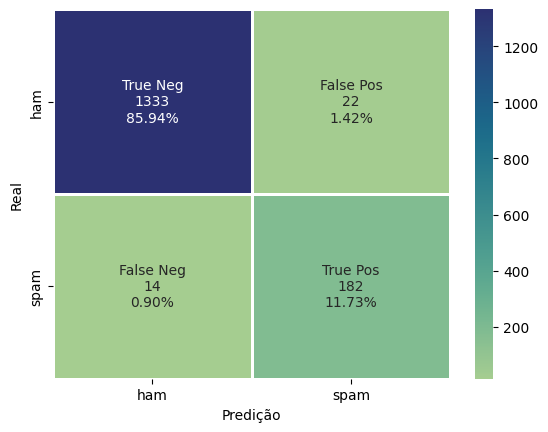

In [1445]:
classes = data['classification'].unique()

cf_matrix = confusion_matrix(y_test, predictions_naive)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, cmap="crest", annot=labels, linewidth=1, fmt='', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predição')
plt.ylabel("Real")
plt.show()

**Relatório das Principais Métricas de Classificação**

In [1446]:
print(classification_report(y_test, predictions_naive, target_names=classes)) 

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1355
        spam       0.89      0.93      0.91       196

    accuracy                           0.98      1551
   macro avg       0.94      0.96      0.95      1551
weighted avg       0.98      0.98      0.98      1551



### **Redes Neurais Convolucionais – CNN (Convolutional Neural Networks)**

**Dividindo o Conjunto de Dados em Treino, Validação e Teste**

In [1447]:
#dc = data[['text', 'classification']]
#dc.head()

In [1448]:
#X_train_cnn, y_train_cnn, X_valid_cnn, y_valid_cnn, X_test_cnn, y_test_cnn = train_valid_test_split(dc, "classification", train_size=0.7, valid_size=0.15, test_size=0.15)

#y_train_cnn.shape, y_test_cnn.shape, y_valid_cnn.shape

In [1449]:
#X_train

In [1450]:
#X_train_cnn.values

In [1451]:
#X_train_cnn = np.reshape(X_train_cnn.values, -1)
#X_test_cnn = np.reshape(X_test_cnn.values, -1)
#X_valid_cnn = np.reshape(X_valid_cnn.values, -1)

#X_train_cnn

In [1452]:
X = data['text'].values
y = data['classification'].values

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


#### **Codificando os Rótulos de Destino**

In [1453]:
# O LabelEncoder é usado para codificar rótulos de destino com valor entre 0 e n_classes-1.
# Este transformador deve ser usado para codificar valores alvo, ou seja y, e não a entrada X.

label = LabelEncoder()

y_train_cnn = label.fit_transform(y_train_cnn)

y_test_cnn = label.transform(y_test_cnn)

#y_valid_cnn = label.transform(y_valid_cnn)

In [1454]:
y_train_cnn

array([0, 0, 0, ..., 1, 0, 0])

In [1455]:
label.inverse_transform(y_train_cnn)

array(['ham', 'ham', 'ham', ..., 'spam', 'ham', 'ham'], dtype=object)

ham é 0

spam é 1

In [1456]:
#preprocessed data: Lemm + stopword removal 
X_train_1_cnn = text_processing(X_train_cnn, True, 'L')
X_test_1_cnn = text_processing(X_test_cnn, True, 'L') 
#X_valid_1_cnn = text_processing(X_valid_cnn, True, 'L') 

#preprocessed data: Lemm + no stopword removal 
X_train_2_cnn = text_processing(X_train_cnn, False, 'L')
X_test_2_cnn = text_processing(X_test_cnn, False, 'L') 
#X_valid_2_cnn = text_processing(X_valid_cnn, False, 'L') 

#preprocessed data: Stem + stopword removal 
X_train_3_cnn = text_processing(X_train_cnn, True, 'S')
X_test_3_cnn = text_processing(X_test_cnn, True, 'S') 
#X_valid_3_cnn = text_processing(X_valid_cnn, True, 'S')

#preprocessed data: Stem + no stopword removal 
X_train_4_cnn = text_processing(X_train_cnn, False, 'S')
X_test_4_cnn = text_processing(X_test_cnn, False, 'S') 
#X_valid_4_cnn = text_processing(X_valid_cnn, False, 'S') 

100%|██████████| 1551/1551 [00:00<00:00, 3344.85it/s]


**Tokenização - convertendo dados textuais em uma representação numérica**

In [1457]:
def tokenizer(X_train, X_test):
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    sequences_train = tokenizer.texts_to_sequences(X_train)
    #sequences_valid = tokenizer.texts_to_sequences(X_valid)
    sequences_test = tokenizer.texts_to_sequences(X_test)

    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    return sequences_train, sequences_test, vocab_size, word_index
    #return sequences_train, sequences_valid, sequences_test, vocab_size, word_index

In [1458]:
sequences_train_1, sequences_test_1, vocab_size_1, word_index_1 = tokenizer(X_train_1_cnn, X_test_1_cnn)
sequences_train_2, sequences_test_2, vocab_size_2, word_index_2 = tokenizer(X_train_2_cnn, X_test_2_cnn)
sequences_train_3, sequences_test_3, vocab_size_3, word_index_3 = tokenizer(X_train_3_cnn, X_test_3_cnn)
sequences_train_4, sequences_test_4, vocab_size_4, word_index_4 = tokenizer(X_train_4_cnn, X_test_4_cnn)


#sequences_train_1, sequences_valid_1, sequences_test_1, vocab_size_1, word_index_1 = tokenizer(X_train_1_cnn, X_valid_1_cnn, X_test_1_cnn)
#sequences_train_2, sequences_valid_2, sequences_test_2, vocab_size_2, word_index_2 = tokenizer(X_train_2_cnn, X_valid_2_cnn, X_test_2_cnn)
#sequences_train_3, sequences_valid_3, sequences_test_3, vocab_size_3, word_index_3 = tokenizer(X_train_3_cnn, X_valid_3_cnn, X_test_3_cnn)
#sequences_train_4, sequences_valid_4, sequences_test_4, vocab_size_4, word_index_4 = tokenizer(X_train_4_cnn, X_valid_4_cnn, X_test_4_cnn)

In [1459]:
print(sequences_train_1)

[[36, 25, 2666, 13], [84, 15, 189, 2667, 34, 2668, 2669, 14, 2670, 617, 15, 1372, 360, 6, 2671, 678], [45, 326, 854, 15, 41, 72, 1373, 37, 2, 2672, 60, 280, 1820, 2, 44, 27, 2, 64, 3, 261], [204, 855, 185, 2, 400, 75], [7, 48, 341, 84, 1374, 2673, 51, 1821, 140], [42, 14, 856], [38, 113, 227, 262, 167], [263, 17, 379, 110, 2, 2, 342, 80, 78, 361, 3, 28, 186, 54, 327, 527, 238], [2674, 94, 1375, 574], [2675, 56, 51, 1143, 60, 56, 51, 72, 20, 56, 51, 362, 197, 1376, 618, 976, 618], [977, 401, 2676, 168, 528, 41, 402, 37, 162, 118], [228, 2677, 575, 89, 2678, 2, 99], [1822, 114, 761, 2679, 248], [679, 1377, 174, 59, 56, 1378], [20, 229, 680, 529, 123, 6, 2680, 163], [124, 363, 59, 115, 2, 43, 2681], [576, 5, 301, 530, 281, 264, 190, 10, 343, 681, 198, 32, 429, 1379, 91, 857, 125, 97, 978, 265], [2, 19, 92, 1823], [2682, 1144, 2, 26, 2683, 2684, 1380, 1145, 2, 327, 20, 1144, 1824, 2685, 1380, 141, 2686, 1145, 1145], [83, 2687, 2688, 75], [328, 2689, 216, 108, 430, 14, 858, 430, 14, 39, 126

#### **Sem Word Embeddings Pré-treinado**

O texto das avaliações foi convertido para inteiros, onde cada inteiro representa uma palavra específica no dicionário. 

As avaliações — os arrays de inteiros — devem ser convertidas em tensores (tensors) antes de alimentar a rede neural.

Isso é como se parece a primeira revisão

In [1460]:
print('Texto em Formato Númerico: ', sequences_train_1[0])
print('Tamanho: ', len(sequences_train_1[0]))

Texto em Formato Númerico:  [36, 25, 2666, 13]
Tamanho:  4


As avaliações têm tamanhos diferentes. O código abaixo mostra o número de palavras da primeira e segunda avaliação. Sabendo que o número de entradas da rede neural tem que ser o mesmo, temos que resolver isto.

In [1461]:
print(f"Tamanho do Primeiro Texto: {len(sequences_train_1[0])} \nTamanho do Segundo Texto: {len(sequences_train_1[1])}")

Tamanho do Primeiro Texto: 4 
Tamanho do Segundo Texto: 16


Como as mensagens (texto) no conjunto de dados são de tamanho variável, usaremos o preenchimento para fazer 
com que todas as mensagens tenham o mesmo tamanho. Podemos usar o comprimento máximo da sequência para preencher as mensagens. 
No entanto, também podemos dar uma olhada na distribuição 
dos comprimentos de sequência no conjunto de treino para encontrar o comprimento de preenchimento correto.

In [1462]:
# Determina o tamanho do vocabulário
print("Tamanho do Vocabulário: ", vocab_size_1)

# Identificando o comprimento da maior sequência do conjunto de treinamento
names = [len(n) for n in sequences_train_1]
print("Comprimento da maior sequência: ", max(names))

Tamanho do Vocabulário:  5798
Comprimento da maior sequência:  77


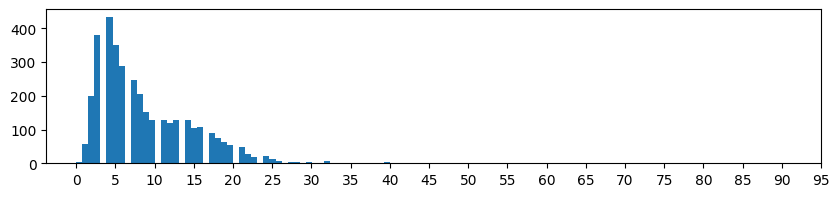

In [1463]:
# Identificando a frêquencia dos comprimentos das sequência de treinamento
plt.figure(figsize=(10,2))
plt.hist(names, bins = 100)
x_ticks = np.arange(0, 100, 5)
plt.xticks(x_ticks)
plt.show()

Podemos ver claramente que a maioria das mensagens tem um comprimento de 25 palavras ou menos. 

Considerando que o comprimento máximo é 77. Portanto, se selecionarmos 77 como o comprimento de preenchimento, 
todas as sequências de entrada terão comprimento 77 e a maioria dos tokens nessas sequências serão tokens de preenchimento que 
não ajudarão o modelo a aprender nada útil e além disso, tornará o treinamento mais lento.

Portanto, definiremos 25 como o comprimento do preenchimento.

#### **Padronização (ou Preenchimento de Sequências)**

Já que as avaliações devem ter o mesmo tamanho, usaremos a função pad_sequences para padronizar os tamanhos.

In [1464]:
max_length = 25

padded_train_1 = pad_sequences(sequences_train_1, maxlen=max_length, padding='post', truncating='post')
#padded_valid_1 = pad_sequences(sequences_valid_1, maxlen=max_length, padding='post', truncating='post')
padded_test_1 = pad_sequences(sequences_test_1, maxlen=max_length, padding='post', truncating='post')

padded_train_2 = pad_sequences(sequences_train_2, maxlen=max_length, padding='post', truncating='post')
#padded_valid_2 = pad_sequences(sequences_valid_2, maxlen=max_length, padding='post', truncating='post')
padded_test_2 = pad_sequences(sequences_test_2, maxlen=max_length, padding='post', truncating='post')

padded_train_3 = pad_sequences(sequences_train_3, maxlen=max_length, padding='post', truncating='post')
#padded_valid_3 = pad_sequences(sequences_valid_3, maxlen=max_length, padding='post', truncating='post')
padded_test_3 = pad_sequences(sequences_test_3, maxlen=max_length, padding='post', truncating='post')

padded_train_4 = pad_sequences(sequences_train_4, maxlen=max_length, padding='post', truncating='post')
#padded_valid_4 = pad_sequences(sequences_valid_4, maxlen=max_length, padding='post', truncating='post')
padded_test_4 = pad_sequences(sequences_test_4, maxlen=max_length, padding='post', truncating='post')

In [1465]:
padded_train_1

array([[  36,   25, 2666, ...,    0,    0,    0],
       [  84,   15,  189, ...,    0,    0,    0],
       [  45,  326,  854, ...,    0,    0,    0],
       ...,
       [1812,   53, 5794, ...,    0,    0,    0],
       [ 167,    0,    0, ...,    0,    0,    0],
       [5796, 5797,    0, ...,    0,    0,    0]])

#### **Métrica Balanced Accuracy Customizada com Keras/Tensorflow**

In [1509]:
# O Tensorflow 2 possui uma opção de configuração para executar funções "avidamente", o que permitirá obter valores do Tensor por meio do método .numpy(). 
# Para habilitar a execução antecipada, use o seguinte comando: tf.config.run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [1539]:
# Aplicar limite de decisão para as probabilidades do modelo
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

class CustomBalancedAccuracyA(tf.keras.metrics.Metric):
    def __init__(self, Threshold=0.5, name='CustomBalancedAccuracy', **kwargs):
        super(CustomBalancedAccuracyA, self).__init__(name=name, **kwargs)
        self.Threshold = Threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # O y_true é um array de 1 Dimensão com valores inteiros.
        # O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
        # Precisamos transformar o y_pred em inteiros e converter o array para 1D
        # Iremos usar as funçãoes do Tensorflow
        # 1) Arrendondar os valores do array
        # 2) Transformar o array de 2D para 1D
        # 3) Converter o tipo do array para int32
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
            y_pred= tf.cast(tf.convert_to_tensor(y_pred), dtype='int32')
        else:
            y_pred = tf.cast(tf.reshape(tf.round(y_pred), -1), dtype='int32')

        # O y_pred é um tensor do tipo int32.
        # Vamos converter o y_true para tensor do tipo int32
        y_true = tf.cast(tf.convert_to_tensor(y_true), dtype='int32')

        # Transforma o array em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(y_pred, "bool")

        # Verifica a quantidade de VERDADEIROS POSITIVOS (TP)
        # Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
        #  A    and    B       S
        # True       True  = True
        # False      False = False
        # True       True  = False
        # True       True  = False
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        tp = tf.reduce_sum(values)
        
        # Verifica a quantidade de VERDADEIROS NEGATIVOS (TN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        tn = tf.reduce_sum(values)
        
        # Verifica a quantidade de FALSO POSITIVO (FP)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        fp = tf.reduce_sum(values)

        # Verifica a quantidade de FALSO NEGATIVO (FN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        fn = tf.reduce_sum(values) 

        # assign_add e assign em TensorFlow são usadas para atualizar os valores de tensores que foram definidos como variáveis de estado dentro de uma classe
        # assign_add
        # Função: Incrementa o valor da variável pelo valor especificado.
        # Uso: É útil quando você deseja somar um valor ao valor atual da variável.
        # Exemplo: self.true_positives.assign_add(tn)
        # Isso adiciona o número de verdadeiros positivos encontrados na batch atual ao total acumulado de verdadeiros positivos.
        # Use assign_add quando você precisa acumular valores ao longo do tempo, como ao acumular contagens de verdadeiros positivos, falsos positivos, etc., durante várias iterações ou batches de treinamento.
      
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.true_negatives.assign_add(tn)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        specificity = self.true_negatives / (self.true_negatives + self.false_positives + tf.keras.backend.epsilon())
        balanced_accuracy = (recall + specificity) / 2
        return balanced_accuracy
    
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_negatives.assign(0.0)

#### **Construindo o modelo**

In [1468]:
# Estime os pesos das classes para conjuntos de dados não balanceados.

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))
class_weights

{0: 0.5722872508699779, 1: 3.9584245076586435}

In [1469]:
def build(vocab_size, max_length):
    #####################################################################################################
    # Configurando a arquitetura do modelo  
    model = tf.keras.Sequential()
    
    # --> Camada de Entrada
    # Geralmente, todas as camadas no Keras precisam conhecer a forma de suas entradas para poder criar seus pesos
    # Neste caso, você deve iniciar seu modelo passando um objeto Input para seu modelo, para que ele conheça sua forma de entrada desde o início
    # Modelos construídos com um formato de entrada predefinido como esse sempre possuem pesos (mesmo antes de ver qualquer dado) e sempre possuem um formato de saída definido.
    # Em geral, é uma prática recomendada sempre especificar antecipadamente o formato de entrada de um modelo Sequencial, se você souber o que é.
    # Uma alternativa simples é apenas passar um argumento input_shape para sua primeira camada:
    # Exemplo: model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=max_length, input_shape=(max_length,)))
    # No entanto, o exemplo acima gera um warning: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    # https://keras.io/guides/sequential_model/
    # https://www.tensorflow.org/guide/keras/sequential_model?hl=pt-br
    model.add(tf.keras.Input(shape=(max_length,)))

    # Adicionando Camada de Incorporação - Transforma inteiros positivos (índices) em vetores densos de tamanho fixo.
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=max_length))

    # --> Camadas Intermediárias
    # Adicionando Camada de Convolução
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))

    # Adicionando Camada de Pooling
    model.add(tf.keras.layers.GlobalMaxPooling1D())
                              
    # Adicionando Camada Totalmente Conectada
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.30))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.30))

    # --> Camada de Saída                 
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    #####################################################################################################

    return model

In [1470]:
def cnn(vocab_size, max_length, padded_train, y_train):
    #####################################################################################################
    # Definição do modelo
    model = build(vocab_size, max_length)

    # Transforma modelos do Keras em estimadores do Scikit-Learn
    # Essa transformação permite a utilização dos métodos de validação cruzada e otimização de hiperparâmetros do Scikit-Learn
    clf = KerasClassifier(model=model, 
                          verbose=0, 
                          epochs=40, 
                          batch_size=512, 
                          class_weight=class_weights,
                          #metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')], # Como vamos fazer validação cruzada, não precisamos definir aqui a métrica 
                          optimizer=tf.keras.optimizers.Adam(name='adam', learning_rate=0.001),
                          loss=tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]) 
    
    # Instancia o Classificador para Definir o Limite de Decisão (Threshold)
    # O TunedThresholdClassifierCV é um classificador que pós-ajusta o limite de decisão usando validação cruzada.
    # Este estimador pós-ajusta o limite de decisão (ponto de corte) que é usado para converter estimativas de probabilidade posteriores (ou seja, saída de predict_proba) 
    # ou pontuações de decisão (ou seja, saída de decision_function) em um rótulo de classe. O ajuste é feito otimizando uma métrica binária, potencialmente restringida por outra métrica.
    model_tuned = TunedThresholdClassifierCV(clf, scoring='balanced_accuracy') 

    # Treina o Modelo e Ajusta o Limite de Decisão
    model_tuned.fit(padded_train, y_train)
    print(f'Threshold {model_tuned.best_threshold_:.3f}')

    # Validação Cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model_tuned, padded_train, y_train, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
    print("Média: {} Desvio Padrão: {}".format(round(scores.mean(), 2), round(scores.std(),3)))

    #####################################################################################################

    return model_tuned

In [1471]:
#Lemm + stopword removal 
print("--> Lemm + stopword removal") 
model_cnn_1 = cnn(vocab_size_1, max_length, padded_train_1, y_train_cnn)

#Lemm + no stopword removal 
print("\n--> Lemm + no stopword removal") 
model_cnn_2 = cnn(vocab_size_2, max_length, padded_train_2, y_train_cnn)

#Stem + stopword removal 
print("\n--> Stem + stopword removal") 
model_cnn_3 = cnn(vocab_size_3, max_length, padded_train_3, y_train_cnn)

#Stem + no stopword removal 
print("\n--> Stem + no stopword removal") 
model_cnn_4 = cnn(vocab_size_4, max_length, padded_train_4, y_train_cnn)

--> Lemm + stopword removal
Threshold 0.061
Média: 0.96 Desvio Padrão: 0.014

--> Lemm + no stopword removal
Threshold 0.424
Média: 0.96 Desvio Padrão: 0.017

--> Stem + stopword removal
Threshold 0.010
Média: 0.96 Desvio Padrão: 0.011

--> Stem + no stopword removal
Threshold 0.273
Média: 0.96 Desvio Padrão: 0.017


#### **Modelo Escolhido:** Stem + no stopword removal

Escolhemos o modelo que obteve o melhor desempenho na validação cruzada, ou seja, a melhor média e menor desvio padrão.

Um desvio padrão baixo indica que os dados estão próximos da média ou do valor esperado.

O modelo que usa stemização, com remoção de palavras irrelevantes supera os demais modelos com uma pontuação média de balanced_accuracy de 0.96 e desvio padrão de 0.011. 

### **Resultado Final**

A CNN obteve melhor desempenho na detecção de spam, apresentando resultados superiores quando comparados com o modelo Multinomial Naive Bayes.

Naive Bayes:
* Balanced_Accuracy: 96.0 %
* F1-Score: 95.0 %

CNN: 
* Balanced_Accuracy: 96.0 %
* F1-Score: 96.0 %

In [1568]:
#Lemm + stopword removal 
print("--> AVALIAÇÃO NO TESTE: Lemm + stopword removal + CountVectorizer") 

# Predição no Conjunto de Teste
predictions_naive = model_count_1.predict(X_test_1_count)

# Avaliação Final do Modelo
evaluate_model(y_test, predictions_naive)

--> AVALIAÇÃO NO TESTE: Lemm + stopword removal + CountVectorizer
Balanced_Accuracy: 96.0% F1-Score: 95.0%


In [1569]:
# Iremos reinstanciar o modelo
# 1) Usando Keras
model = build(vocab_size_3, max_length)
   
# Configurando o modelo para treinamento
model.compile(optimizer=tf.keras.optimizers.Adam(name='adam', learning_rate=0.001),   # O learning_rate padrão é 0.001 
                # Já que é um problema de classificação binário e o modelo tem como saída uma probabilidade usaremos a função loss "binary_crossentropy". A binary_crossentropy é a melhor função de loss para tratar probabilidades— ela mede a "distância" entre as distribuições de probabilidade, ou, no nosso caso, sobre a distribuição real e as previsões.
                loss=tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'), 
                # Usaremos como métrica a binary_accuracy. Essa métrica é utilizada especificamente em problemas de classificação binária e calcula com que frequência as previsões correspondem aos rótulos binários.
                metrics=[CustomBalancedAccuracyA(model_cnn_3.best_threshold_)])

# Resumo do modelo
#model.summary()

# Treinando o modelo
history = model.fit(x=padded_train_3, 
                    y=y_train_cnn,
                    epochs=40,
                    batch_size=512,
                    verbose=1,
                    class_weight=class_weights,
                    #validation_data=(padded_valid_3, y_valid_cnn),
                    validation_split=0.15,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

# Fazendo as predições
# O array do treino, validação e teste é um array de 1D com ZEROs e UMs [0, 1]
# Faz a predição
# Arredonda os valores da predição para 1 ou 0
# Transforma o array em 1D
# Transforma o tipo do array em INT
ytrain = model.predict(padded_train_3)
ytest = model.predict(padded_test_3)
ytest


Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.6809 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.6708
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.6586 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.6160
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.6185 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.5286
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.5268 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.4218
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.3889 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.2719
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - CustomBalancedAccuracy: 0.5000 - loss: 0.2583 - val_CustomBalancedAccuracy: 0.5000 - val_loss: 0.1517
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - CustomBalancedAccuracy: 

array([[6.3657477e-05],
       [9.9999976e-01],
       [1.6565515e-04],
       ...,
       [2.3623386e-05],
       [1.0390350e-05],
       [7.5391501e-05]], dtype=float32)

In [1570]:
y_test_cnn

array([0, 1, 0, ..., 0, 0, 0])

In [1571]:
np.reshape(ytest, -1)

array([6.3657477e-05, 9.9999976e-01, 1.6565515e-04, ..., 2.3623386e-05,
       1.0390350e-05, 7.5391501e-05], dtype=float32)

In [1572]:
# Scikit-Learn
bal_acc_test_sc = np.round(balanced_accuracy_score(y_test_cnn, to_labels(np.reshape(ytest, -1), model_cnn_3.best_threshold_)), 2)*100
bal_acc_train_sc = np.round(balanced_accuracy_score(y_train_cnn, to_labels(np.reshape(ytrain, -1), model_cnn_3.best_threshold_)), 2)*100

# Métrica Customizada
m = CustomBalancedAccuracyA(model_cnn_3.best_threshold_)
m.update_state(y_test_cnn, ytest)
bal_acc_test_cm = tf.keras.ops.round(tf.convert_to_tensor(m.result().numpy(), dtype=tf.float64), 2)*100

m = CustomBalancedAccuracyA(model_cnn_3.best_threshold_)
m.update_state(y_train_cnn, ytrain)
bal_acc_train_cm = tf.keras.ops.round(tf.convert_to_tensor(m.result().numpy(), dtype=tf.float64), 2)*100


#print(f"Balanced Accuracy do Treino: {bal_acc_train_sc} {bal_acc_train_cm}")
print(f"Balanced Accuracy do Teste: {bal_acc_test_sc} {bal_acc_test_cm}")

Balanced Accuracy do Teste: 96.0 96.0


**Visualização das Métricas da CNN Durante o Treinamento**

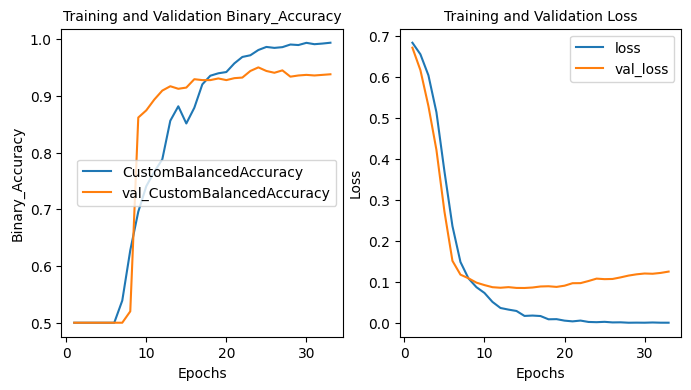

In [1573]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

acc = history.history['CustomBalancedAccuracy']
val_acc = history.history['val_CustomBalancedAccuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=loss, ax=ax[1], label='loss')
sns.lineplot(x=epochs, y=val_loss, ax=ax[1], label='val_loss')
ax[1].set_title("Training and Validation Loss", size=10)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')


sns.lineplot(x=epochs, y=acc, ax=ax[0], label='CustomBalancedAccuracy')
sns.lineplot(x=epochs, y=val_acc, ax=ax[0], label='val_CustomBalancedAccuracy')
ax[0].set_title("Training and Validation Binary_Accuracy", size=10)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Binary_Accuracy')


plt.show()

**Visualização da Matriz de Classificação**

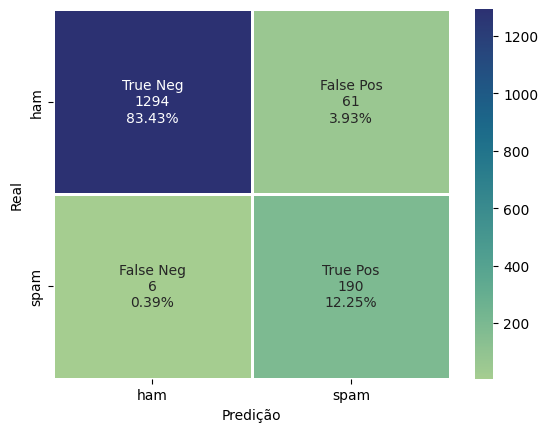

In [1579]:
classes = data['classification'].unique()

predictions_cnn = to_labels(np.reshape(ytest, -1), model_cnn_3.best_threshold_)

cf_matrix = confusion_matrix(y_test_cnn, predictions_cnn)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, cmap="crest", annot=labels, linewidth=1, fmt='', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predição')
plt.ylabel("Real")
plt.show()

**Relatório das Principais Métricas de Classificação**

In [1580]:
print(classification_report(y_test_cnn, predictions_cnn, target_names=classes))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1355
        spam       0.76      0.97      0.85       196

    accuracy                           0.96      1551
   macro avg       0.88      0.96      0.91      1551
weighted avg       0.97      0.96      0.96      1551

